# Approximate inference in aGrUM (pyAgrum)

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

There are several approximate inference for BN in aGrUM (pyAgrum). They share the same API than exact inference.
- Loopy Belief Propagation : LBP is an approximate inference that uses exact calculous methods (when the BN os a tree) even if the BN is not a tree. LBP is a special case of inference : the algorithm may not converge and even if it converges, it may converge to anything (but the exact posterior). LBP however is fast and usually gives not so bad results.
- Sampling inference : Sampling inference use sampling to compute the posterior. The sampling may be (very) slow but those algorithms converge to the exac distribution. aGrUM implements :
  - Montecarlo sampling,
  - Weighted sampling,
  - Importance sampling,
  - Gibbs sampling.
- Finally, aGrUM propose the so-called 'loopy version' of the sampling algorithms : the idea is to use LBP as a Dirichlet prior for the sampling algorithm. A loopy version of each sampling algorithm is proposed.

In [1]:
import os

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

def unsharpen(bn):
  """
  Force the parameters of the BN not to be a bit more far from 0 or 1
  """
  for nod in bn.nodes():
    bn.cpt(nod).translate(bn.maxParam() / 10).normalizeAsCPT()

def compareInference(ie,ie2,ax=None):
    """
    compare 2 inference by plotting all the points from (posterior(ie),posterior(ie2))
    """
    exact=[]
    appro=[]
    errmax=0
    for node in bn.nodes():
        # Tensors as list
        exact+=ie.posterior(node).tolist()
        appro+=ie2.posterior(node).tolist()
        errmax=max(errmax,
                   (ie.posterior(node)-ie2.posterior(node)).abs().max())
    
    if errmax<1e-10: errmax=0
    if ax==None:
        fig=plt.Figure(figsize=(4,4))
        ax=plt.gca() # default axis for plt
        
           
    ax.plot(exact,appro,'ro')
    ax.set_title("{} vs {}\n {}\nMax error {:2.4} in {:2.4} seconds".format(
        str(type(ie)).split(".")[2].split("_")[0][0:-2], # name of first inference
        str(type(ie2)).split(".")[2].split("_")[0][0:-2], # name of second inference
        ie2.messageApproximationScheme(),
        errmax,
        ie2.currentTime())
                )

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
bn=gum.loadBN("res/alarm.dsl")
unsharpen(bn)

ie=gum.LazyPropagation(bn)
ie.makeInference()

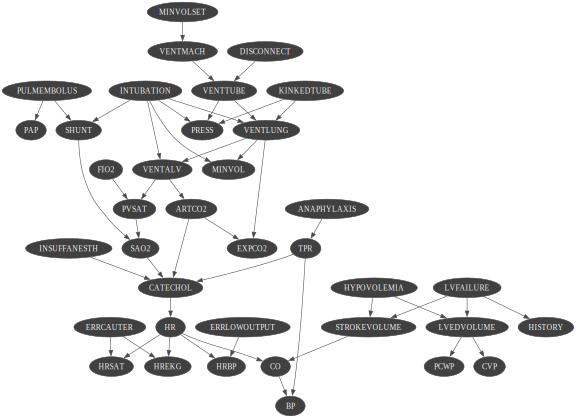

In [3]:
gnb.showBN(bn,size='8')


### First, an exact inference.

In [4]:
gnb.sideBySide(gnb.getJunctionTreeMap(bn),gnb.getInference(bn,size="8")) # using LazyPropagation by default
print(ie.posterior("KINKEDTUBE"))



  KINKEDTUBE       |
TRUE     |FALSE    |
---------|---------|
 0.1167  | 0.8833  |



## Gibbs Inference

### Gibbs inference with default parameters

Gibbs inference iterations can be stopped :
- by the value of error (epsilon)
- by the rate of change of epsilon (MinEpsilonRate)
- by the number of iteration (MaxIteration)
- by the duration of the algorithm (MaxTime)


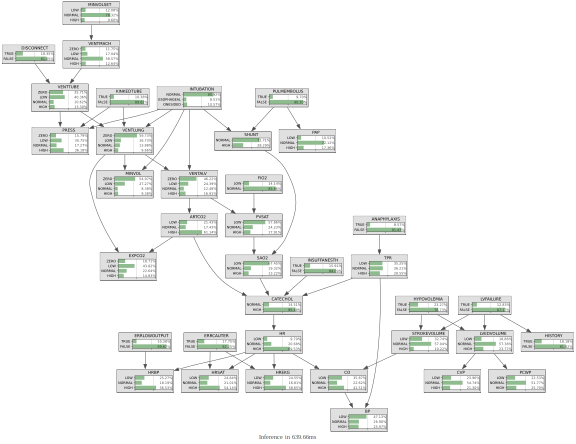


  KINKEDTUBE       |
TRUE     |FALSE    |
---------|---------|
 0.1038  | 0.8962  |

stopped with rate=0.00673795


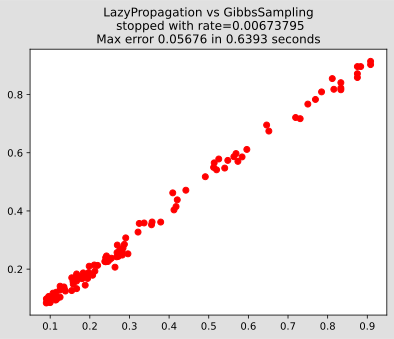

In [5]:
ie2=gum.GibbsSampling(bn)
ie2.setEpsilon(1e-2)
gnb.showInference(bn,engine=ie2,size="8")
print(ie2.posterior("KINKEDTUBE"))
print(ie2.messageApproximationScheme())
compareInference(ie,ie2)

With default parameters, this inference has been stopped by a low value of rate.

### Changing parameters

In [6]:
ie2=gum.GibbsSampling(bn)
ie2.setMaxIter(1000)
ie2.setEpsilon(5e-3)
ie2.makeInference()

print(ie2.posterior(2))
print(ie2.messageApproximationScheme())


  INTUBATION                 |
NORMAL   |ESOPHAGEA|ONESIDED |
---------|---------|---------|
 0.7436  | 0.1664  | 0.0900  |

stopped with max iteration=1000


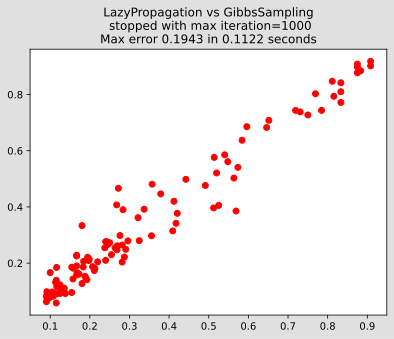

In [7]:
compareInference(ie,ie2)


  INTUBATION                 |
NORMAL   |ESOPHAGEA|ONESIDED |
---------|---------|---------|
 0.9300  | 0.0100  | 0.0600  |

stopped with epsilon=0.201897


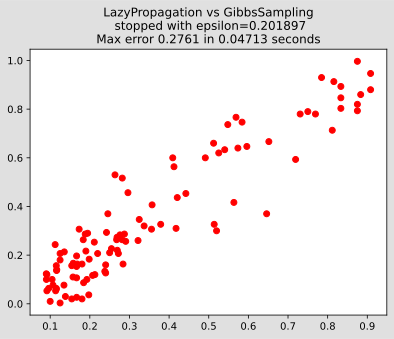

In [8]:
ie2=gum.GibbsSampling(bn)
ie2.setMaxTime(3)
ie2.makeInference()

print(ie2.posterior(2))
print(ie2.messageApproximationScheme())
compareInference(ie,ie2)

### Looking at the convergence

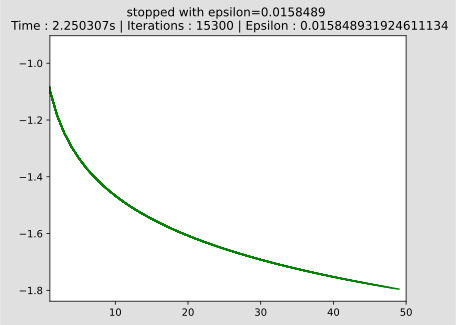

In [9]:
ie2=gum.GibbsSampling(bn)
ie2.setEpsilon(10**-1.8)
ie2.setBurnIn(300)
ie2.setPeriodSize(300)
ie2.setDrawnAtRandom(True)
gnb.animApproximationScheme(ie2)
ie2.makeInference()

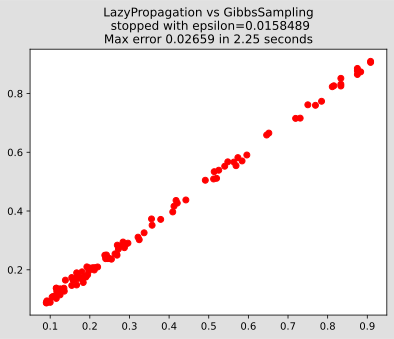

In [10]:
compareInference(ie,ie2)

## Importance Sampling

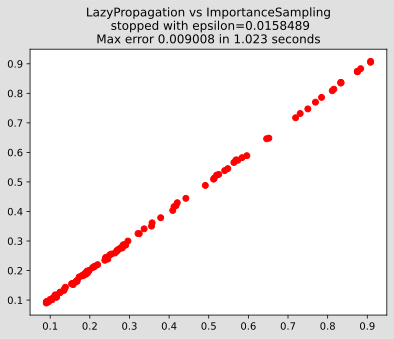

In [11]:
ie4=gum.ImportanceSampling(bn)
ie4.setEpsilon(10**-1.8)
ie4.setMaxTime(10) #10 seconds for inference
ie4.setPeriodSize(300)
ie4.makeInference()
compareInference(ie,ie4)

## Loopy Gibbs Sampling

Every sampling inference has a 'hybrid' version which consists in using a first loopy belief inference as a prior for the probability estimations by sampling.

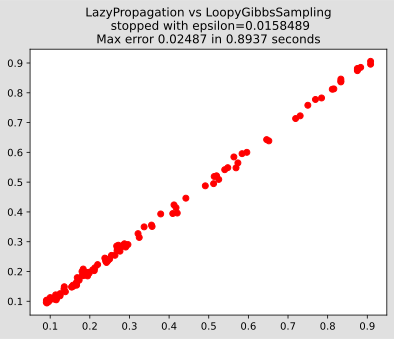

In [12]:
ie3=gum.LoopyGibbsSampling(bn)

ie3.setEpsilon(10**-1.8)
ie3.setMaxTime(10) #10 seconds for inference
ie3.setPeriodSize(300)
ie3.makeInference()
compareInference(ie,ie3)


## Comparison of approximate inference


These computations may be a bit long 

In [13]:
def compareAllInference(bn,evs={},epsilon=10**-1.6,epsilonRate=1e-8,maxTime=20):
    ies=[gum.LazyPropagation(bn),
         gum.LoopyBeliefPropagation(bn),
         gum.GibbsSampling(bn),
         gum.LoopyGibbsSampling(bn),
         gum.WeightedSampling(bn),
         gum.LoopyWeightedSampling(bn),
         gum.ImportanceSampling(bn),
         gum.LoopyImportanceSampling(bn)]
    
    # burn in for Gibbs samplings
    for i in [2,3]:
        ies[i].setBurnIn(300)
        ies[i].setDrawnAtRandom(True)
        
    for i in range(2,len(ies)):
        ies[i].setEpsilon(epsilon)
        ies[i].setMinEpsilonRate(epsilonRate)
        ies[i].setPeriodSize(300)
        ies[i].setMaxTime(maxTime)
        
    for i in range(len(ies)):
        ies[i].setEvidence(evs)
        ies[i].makeInference()
        
    fig, axes = plt.subplots(1,len(ies)-1,figsize=(35, 3),num='gpplot')
    for i in range(len(ies)-1):
        compareInference(ies[0],ies[i+1],axes[i])


### Inference stopped by epsilon


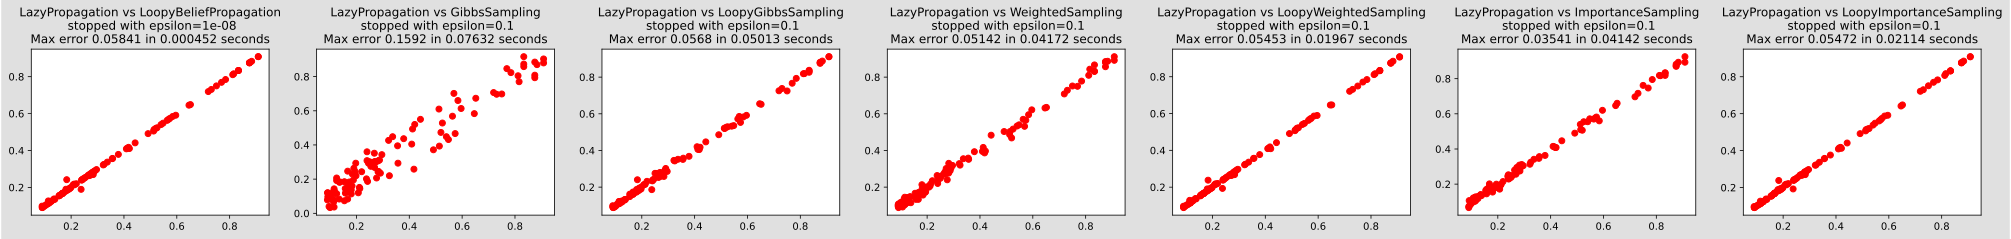

In [14]:
compareAllInference(bn,epsilon=1e-1)

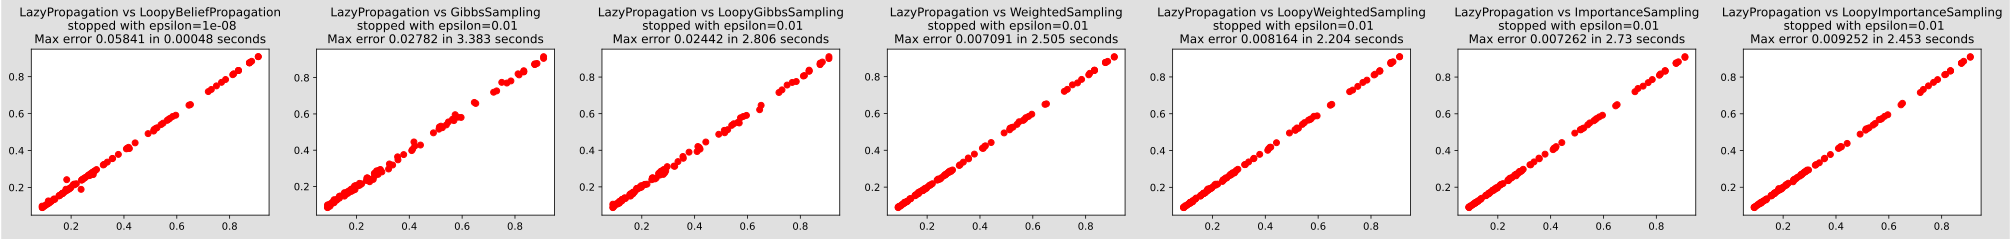

In [15]:
compareAllInference(bn,epsilon=1e-2)

### inference stopped by time

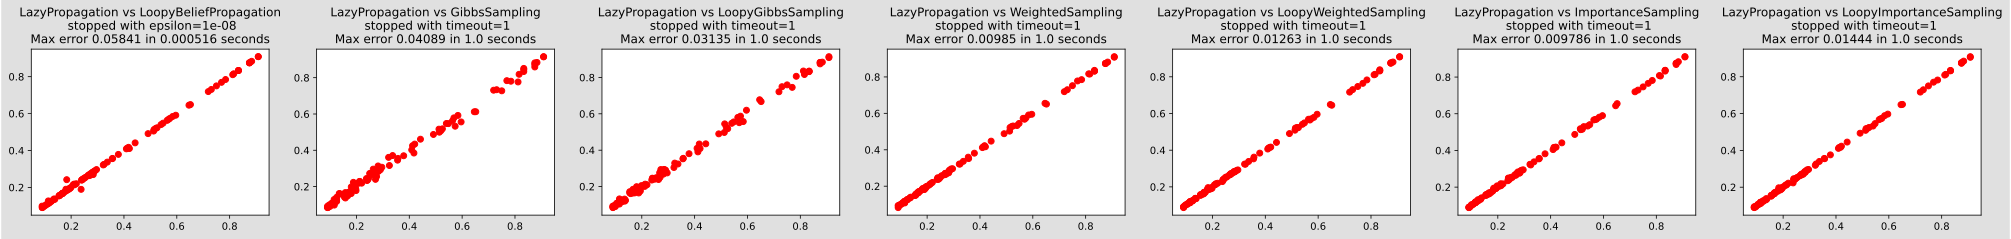

In [16]:
compareAllInference(bn,maxTime=1,epsilon=1e-8)

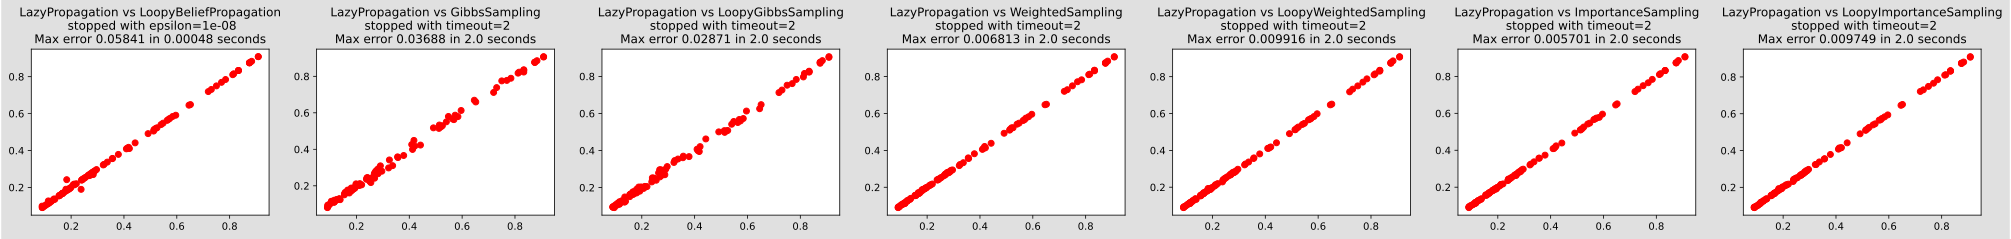

In [17]:
compareAllInference(bn,maxTime=2,epsilon=1e-8)

### Inference with Evidence (more complex)

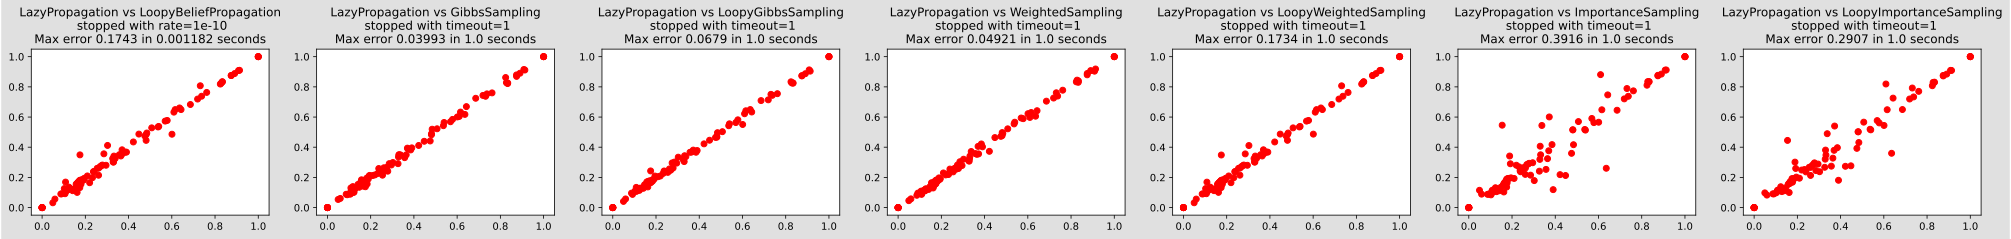

In [18]:
funny={'BP':1,'PCWP':2,'EXPCO2':0,'HISTORY':0}
compareAllInference(bn,maxTime=1,evs=funny,epsilon=1e-8)

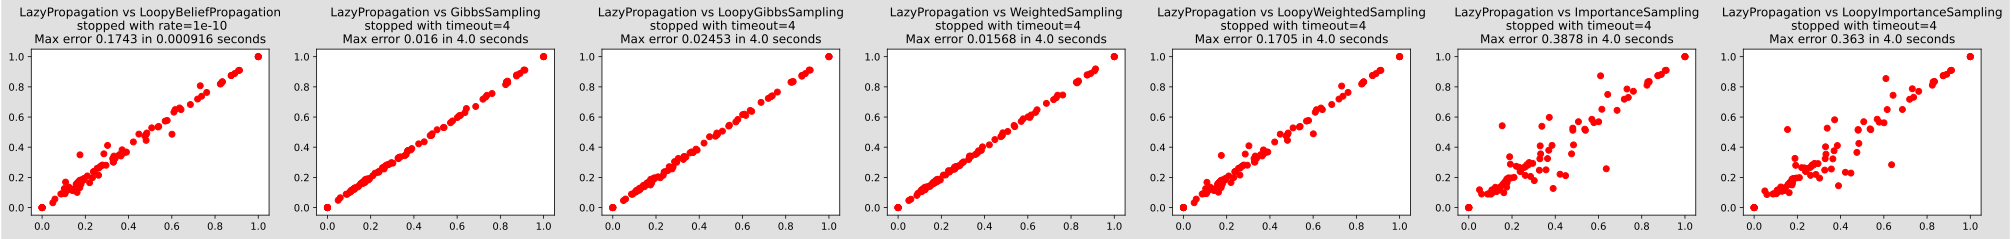

In [19]:
compareAllInference(bn,maxTime=4,evs=funny,epsilon=1e-8)

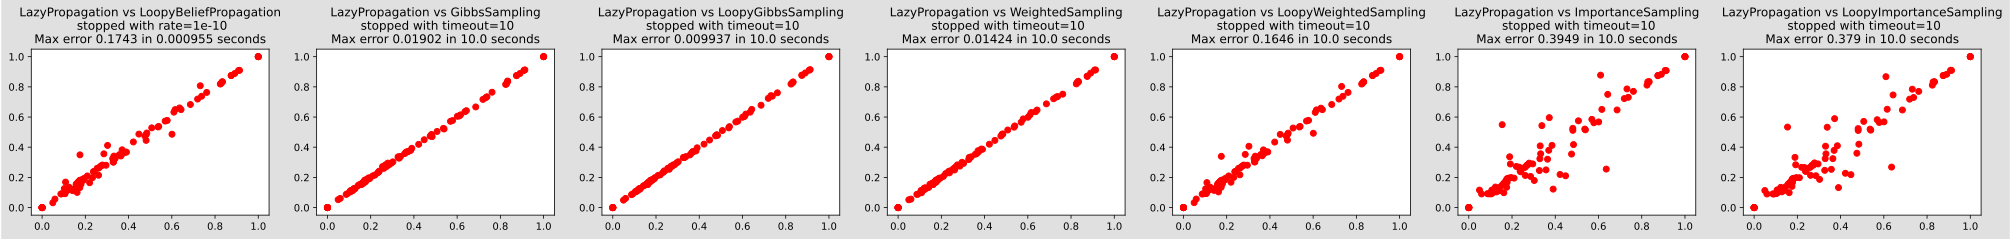

In [20]:
compareAllInference(bn,maxTime=10,evs=funny,epsilon=1e-8)